In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [3]:
DATA_PATH = '/Users/kaansahin/Desktop/InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')

In [4]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()

In [5]:
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
1,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
2,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
3,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
4,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
...,...,...
19995,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly
19996,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly
19997,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly
19998,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly


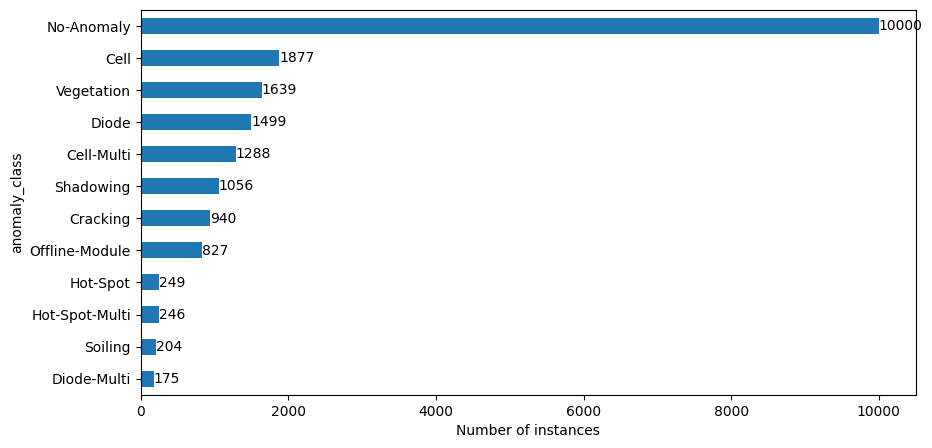

In [5]:
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

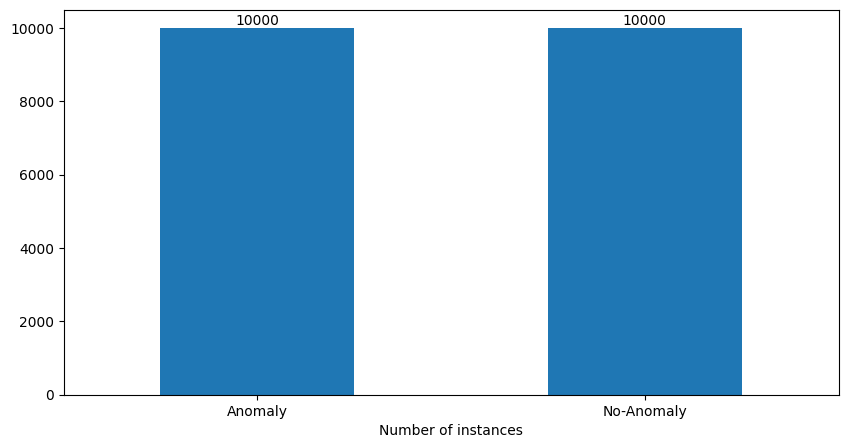

In [6]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

ax = df.anomaly_class.apply(convert_to_binary).value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

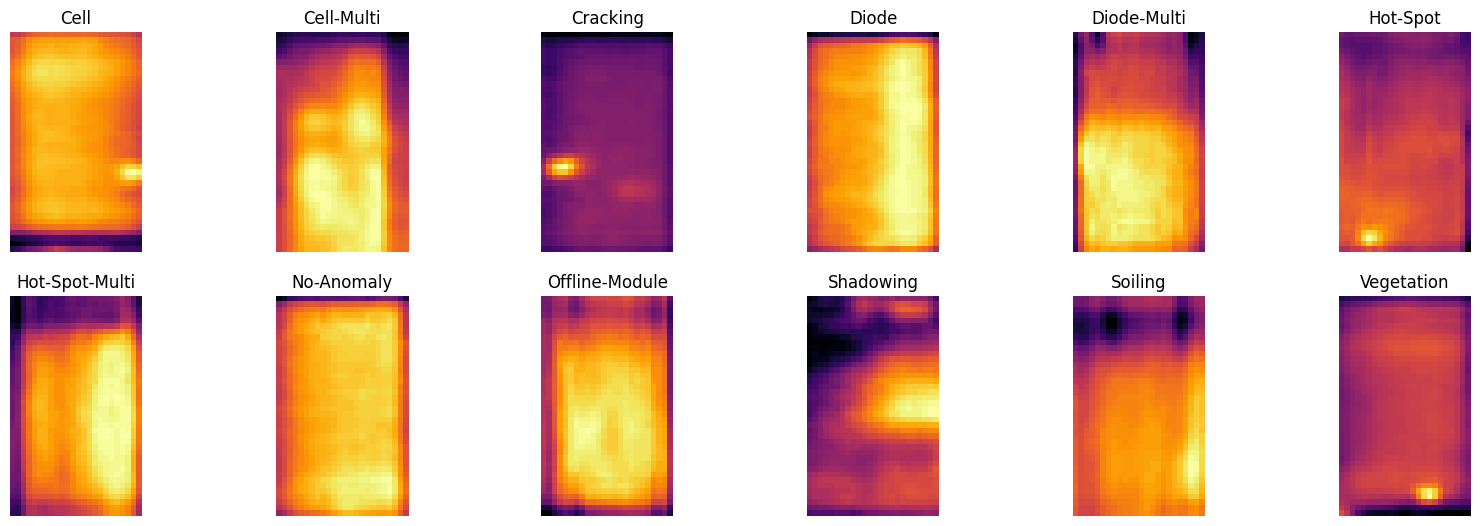

In [7]:
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(20,20))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    image = cv2.imread(image_path, 0)
      
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [6]:
crystal_df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
crystal_df

,image_filepath,anomaly_class
0,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
1,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
2,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
3,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
4,/Users/kaansahin/Desktop/InfraredSolarModules/...,Offline-Module
...,...,...
19995,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly
19996,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly
19997,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly
19998,/Users/kaansahin/Desktop/InfraredSolarModules/...,No-Anomaly


In [9]:
thin_film_df = df.query('anomaly_class == ("Hot-Spot", "Hot-Spot-Multi")')
thin_film_df

,image_filepath,anomaly_class
6722,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot
6723,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot
6724,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot
6725,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot
6726,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot
...,...,...
8152,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot-Multi
8153,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot-Multi
8154,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot-Multi
8155,/Users/kaansahin/Desktop/InfraredSolarModules/...,Hot-Spot-Multi


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [10]:
class_names = crystal_df['anomaly_class'].unique()
num_classes = len(class_names)

In [11]:
train_df, test_df = train_test_split(crystal_df, test_size=0.2, stratify=crystal_df['anomaly_class'])

In [12]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [13]:
# Validation set should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Set image size and batch size
img_width, img_height = 24, 40
batch_size = 32

In [15]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image_filepath',
                                                    y_col='anomaly_class',
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                x_col='image_filepath',
                                                y_col='anomaly_class',
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 15604 validated image filenames belonging to 10 classes.
Found 3901 validated image filenames belonging to 10 classes.


In [16]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])


In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Train the model
epochs = 20
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

Epoch 1/20
488/488 [==============================] - 14s 27ms/step - loss: 1.7174 - accuracy: 0.5121 - val_loss: 1.6626 - val_accuracy: 0.5127
Epoch 2/20
488/488 [==============================] - 13s 26ms/step - loss: 1.6646 - accuracy: 0.5128 - val_loss: 1.6239 - val_accuracy: 0.5124
Epoch 3/20
488/488 [==============================] - 13s 26ms/step - loss: 1.5899 - accuracy: 0.5236 - val_loss: 1.4863 - val_accuracy: 0.5360
Epoch 4/20
488/488 [==============================] - 13s 26ms/step - loss: 1.5303 - accuracy: 0.5353 - val_loss: 1.4458 - val_accuracy: 0.5460
Epoch 5/20
488/488 [==============================] - 13s 26ms/step - loss: 1.4958 - accuracy: 0.5401 - val_loss: 1.4083 - val_accuracy: 0.5573
Epoch 6/20
488/488 [==============================] - 13s 27ms/step - loss: 1.4681 - accuracy: 0.5474 - val_loss: 1.3870 - val_accuracy: 0.5640
Epoch 7/20
488/488 [==============================] - 14s 29ms/step - loss: 1.4584 - accuracy: 0.5502 - val_loss: 1.3513 - val_accuracy:

In [19]:
model.save('pv_module_fraud_detection_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
model.save('pv_module_fraud_detection_model.keras')